<a href="https://colab.research.google.com/github/joshsalako/ai_generated_image_detector/blob/main/AI_generated_image_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Deep Learning for Vision

**Generated by AI detector**: Train a model to detect if images are generated by AI

* Find a dataset of natural images and images generated by AI (here is one such dataset on the [Hugging Face Hub](https://huggingface.co/datasets/competitions/aiornot) but you're welcome to use any dataset you've found.
* Create a training and test set.
* Build a neural network (using Tensorflow, PyTorch, or any framework you like)
* Train it to classify the image as being generated by an AI or not until a reasonable accuracy is reached
* [Upload the the model to the Hugging Face Hub](https://huggingface.co/docs/hub/adding-a-model), and add a link to your model below.
* Look at some of the images that were classified incorrectly. Please explain what you might do to improve your model's performance on these images in the future (you do not need to impelement these suggestions)

**Submission instructions**: Please write your code below and include some examples of images that were classified

## Import Dataset

In [ ]:
! pip install datasets
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
from datasets import load_dataset, Image
df = load_dataset('competitions/aiornot', split = 'train')
df

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/competitions___parquet/competitions--aiornot-f559c639a48093b2/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


Dataset({
    features: ['id', 'image', 'label'],
    num_rows: 18618
})

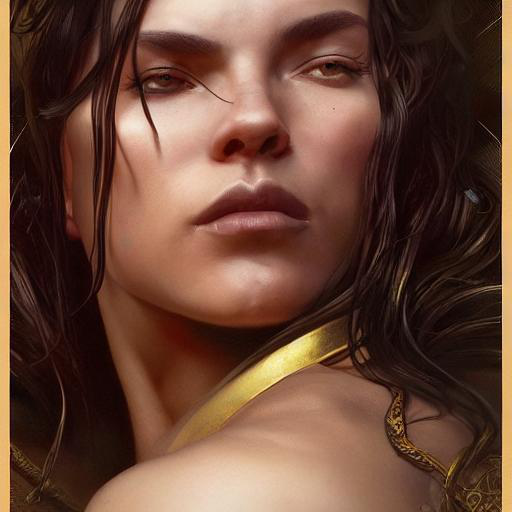

In [ ]:
df[0]['image']

## Data Preprocessing

In [ ]:
from datasets import ClassLabel
feat_sentiment = ClassLabel(num_classes = 2,names=["negative", "positive"])
df = df.cast_column("label", feat_sentiment)
df

Casting the dataset:   0%|          | 0/18618 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'image', 'label'],
    num_rows: 18618
})

Split dataset to train, test and validation in ratio 8:1:1 respectively

In [ ]:
df = df.train_test_split(test_size=0.2, shuffle=True, seed=42,
                         stratify_by_column = "label")
test_valid = df['test'].train_test_split(test_size=0.5, shuffle=True, seed=42,
                                         stratify_by_column = "label")

from datasets import DatasetDict
dataset = DatasetDict({
    'train': df['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'image', 'label'],
        num_rows: 14894
    })
    test: Dataset({
        features: ['id', 'image', 'label'],
        num_rows: 1862
    })
    valid: Dataset({
        features: ['id', 'image', 'label'],
        num_rows: 1862
    })
})

In [ ]:
!pip install transformers
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 86.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 97.6 MB/s eta 0:00:00


/usr/local/lib/python3.9/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Image Data Augementaion and Normalization

In [ ]:
from torchvision.transforms import Compose, Normalize, RandomResizedCrop, ColorJitter, ToTensor, Resize, RandomHorizontalFlip
import torch
import tensorflow as tf

normalize = Normalize(mean=feature_extractor.image_mean,
                      std=feature_extractor.image_std)

train_transforms_ = Compose([Resize(size = (224, 224)),
                       RandomResizedCrop(size=(224, 224)),
                       RandomHorizontalFlip(),
                       ColorJitter(brightness=0.5, hue=0.5),
                       ToTensor(), normalize
                       ])

test_transforms_ = Compose([Resize(size = (224, 224)),
                       ToTensor(), normalize
                       ])

In [ ]:
def to_tensor(values):
  """ Converts torch.Tensor to tf.Tensor with the expected shape"""
  return tf.transpose(tf.convert_to_tensor(values.numpy()), [1, 2, 0])

In [ ]:
def train_transforms(examples):
  """A function to convert image to pixel values in tensor"""
  examples["pixel_values"] = [
      to_tensor(train_transforms_(image.convert("RGB"))) for image in examples["image"]]
  return examples

In [ ]:
def test_transforms(examples):
  """A function to convert image to pixel values in tensor"""
  examples["pixel_values"] = [
      to_tensor(test_transforms_(image.convert("RGB"))) for image in examples["image"]]
  return examples

In [ ]:
#Transform the dataset
dataset['train'].set_transform(train_transforms)

In [ ]:
dataset['train'][0]

{'id': '234.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7FE5FC5A87C0>,
 'label': 0,
 'pixel_values': <tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[-0.1372549 ,  0.19215691, -0.06666666],
         [-0.1372549 ,  0.19215691, -0.06666666],
         [-0.1372549 ,  0.19215691, -0.06666666],
         ...,
         [-0.12156862,  0.20000005, -0.04313725],
         [-0.12941176,  0.19215691, -0.05098039],
         [-0.12941176,  0.19215691, -0.05098039]],
 
        [[-0.1372549 ,  0.19215691, -0.06666666],
         [-0.1372549 ,  0.19215691, -0.06666666],
         [-0.1372549 ,  0.19215691, -0.06666666],
         ...,
         [-0.12156862,  0.20000005, -0.04313725],
         [-0.12941176,  0.19215691, -0.05098039],
         [-0.12941176,  0.19215691, -0.05098039]],
 
        [[-0.1372549 ,  0.19215691, -0.06666666],
         [-0.1372549 ,  0.19215691, -0.06666666],
         [-0.1372549 ,  0.19215691, -0.06666666],
         ...,
      

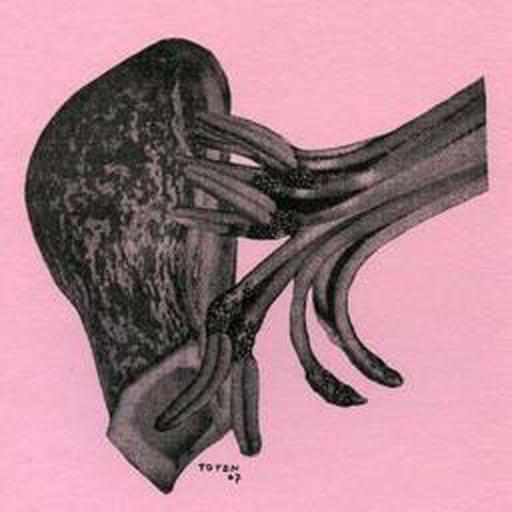

In [ ]:
dataset['train'][0]['image']

In [ ]:
dataset['train'][0]['label']

0

This says it not an AI-generated image

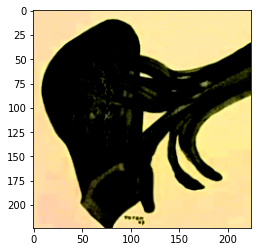

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#Visualize the pixel values
plt.imshow(dataset['train'][0]["pixel_values"])

In [ ]:
dataset['test'].set_transform(test_transforms)
dataset['valid'].set_transform(test_transforms)

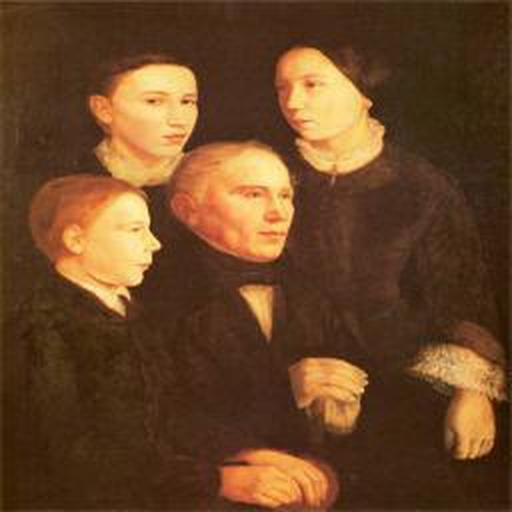

In [ ]:
dataset['test'][2]["image"]

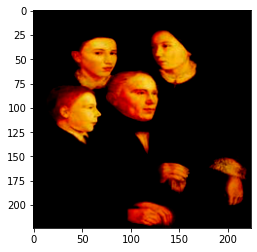

In [ ]:
plt.imshow(dataset['test'][2]["pixel_values"])

In [ ]:
# for batch creation
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator(return_tensors="tf")

## Model Training and Evaluation

Fine-Tunning the VGG16 model

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop

In [ ]:
vgg = VGG16(include_top=True, weights='imagenet')
vgg.summary()

553467096/553467096 [==============================] - 28s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [ ]:
# Pool-out needed layers
transfer_layer = vgg.get_layer('block5_pool')

In [ ]:
conv_model = Model(inputs=vgg.input,
                   outputs=transfer_layer.output)

In [ ]:
#Disable training of those layers
for layer in conv_model.layers:
    layer.trainable = False

In [ ]:
size = (224, 224, 3)
batch_size = 16
num_epochs = 20
lr = 1e-3

#Create the output layers
model = Sequential()
model.add(conv_model)
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
              loss ='binary_crossentropy',
              metrics = [tf.keras.metrics.Precision(), tf.keras.metrics.BinaryAccuracy()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17,942,721
Trainable params: 3,228,033
Non

In [ ]:
# converting our train dataset to tf.data.Dataset
tf_train_dataset = dataset["train"].to_tf_dataset(
    columns=["pixel_values"], label_cols=["label"], shuffle=True,
    batch_size=batch_size, collate_fn=data_collator
)

# converting our valid dataset to tf.data.Dataset
tf_valid_dataset = dataset["valid"].to_tf_dataset(
    columns=["pixel_values"], label_cols=["label"],
    batch_size=batch_size, collate_fn=data_collator
)

# converting our test dataset to tf.data.Dataset
tf_test_dataset = dataset["test"].to_tf_dataset(
    columns=["pixel_values"], label_cols=["label"],
    batch_size=batch_size, collate_fn=data_collator
)

In [ ]:
y_test = np.array([])
for image_batch, labels_batch in tf_test_dataset:
  y_test = np.append(y_test, labels_batch.numpy())

In [ ]:
y_test

array([1., 0., 0., ..., 1., 0., 0.])

In [ ]:
history = model.fit(tf_train_dataset, validation_data = tf_valid_dataset,
                    epochs = num_epochs)

Epoch 1/20
931/931 [==============================] - 280s 290ms/step - loss: 0.4696 - precision: 0.7977 - binary_accuracy: 0.7840 - val_loss: 0.3497 - val_precision: 0.9175 - val_binary_accuracy: 0.8475
Epoch 2/20
931/931 [==============================] - 286s 307ms/step - loss: 0.4039 - precision: 0.8327 - binary_accuracy: 0.8168 - val_loss: 0.3126 - val_precision: 0.9058 - val_binary_accuracy: 0.8614
Epoch 3/20
931/931 [==============================] - 269s 288ms/step - loss: 0.3857 - precision: 0.8396 - binary_accuracy: 0.8240 - val_loss: 0.2843 - val_precision: 0.8873 - val_binary_accuracy: 0.8733
Epoch 4/20
931/931 [==============================] - 281s 301ms/step - loss: 0.3751 - precision: 0.8460 - binary_accuracy: 0.8320 - val_loss: 0.3314 - val_precision: 0.9400 - val_binary_accuracy: 0.8550
Epoch 5/20
931/931 [==============================] - 264s 284ms/step - loss: 0.3671 - precision: 0.8464 - binary_accuracy: 0.8350 - val_loss: 0.2831 - val_precision: 0.9069 - val_bina

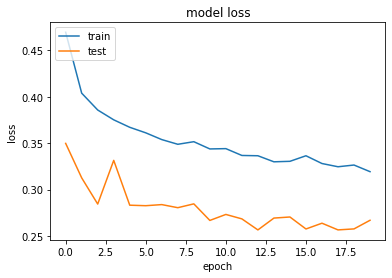

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(tf_test_dataset)

117/117 [==============================] - 22s 191ms/step - loss: 0.2538 - precision: 0.8705 - binary_accuracy: 0.8937


[0.2538071870803833, 0.8704525232315063, 0.8936627507209778]

Push model to Hugging Face

In [ ]:
from huggingface_hub import push_to_hub_keras
push_to_hub_keras(model, 'ai_generated_image_detector')

fingerprint.pb:   0%|          | 0.00/55.0 [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/408k [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/82.5k [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/71.8M [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

'https://huggingface.co/josh-salako/ai_generated_image_detector/tree/main/'

## Model Inspection

In [ ]:
y_hat = model.predict(tf_test_dataset)

117/117 [==============================] - 27s 229ms/step


In [ ]:
pred = np.where(y_hat > 0.49, 1., 0.)
pred

array([[1.],
       [1.],
       [0.],
       ...,
       [1.],
       [0.],
       [0.]])

In [ ]:
pred = pred.transpose().reshape((-1,))
pred

array([1., 1., 0., ..., 1., 0., 0.])

Checking for wrongly predicted images

In [ ]:
ai = []#for ai generated images predicted as not ai
not_ai = []#for non-ai generated images predicted as ai generated

for i, (m, n) in enumerate(zip(y_test, pred)):
    if n != m:
        if n == 0.:
            ai+= [i]
        else:
            not_ai += [i]

In [ ]:
len(not_ai)

151

In [ ]:
len(ai)

52

In [ ]:
def plotter(index, n):
  wrongly_predicted = [dataset["test"][i]['image'] for i in index][:n]
  for i in wrongly_predicted:
    plt.imshow(i)
    plt.show()

## Write up

AI generated images classified wrongly

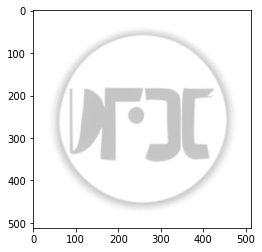

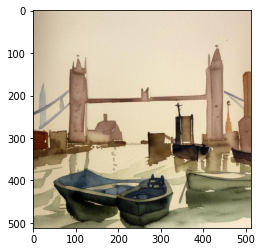

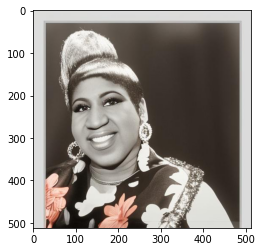

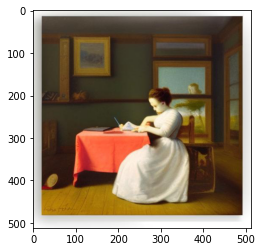

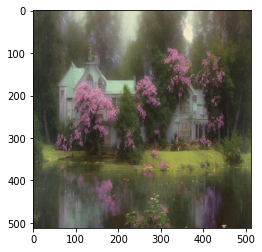

In [ ]:
plotter(ai, 5)

Non-AI generated images classified wrongly

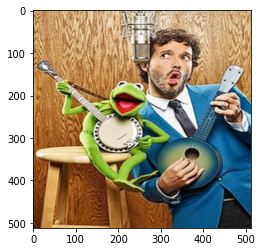

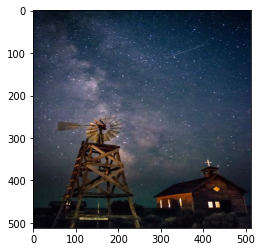

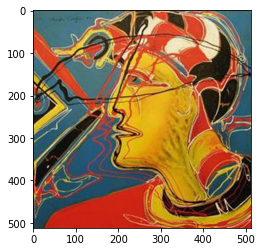

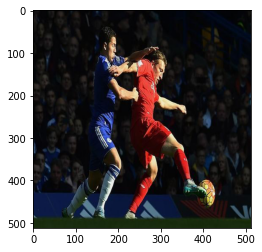

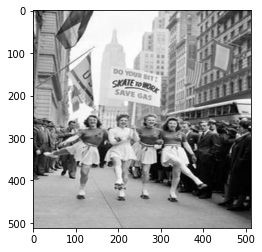

In [ ]:
plotter(not_ai, 5)

Model has 86% and 90% training and testing accuracy respectively.
Here is the model : https://huggingface.co/josh-salako/ai_generated_image_detector/tree/main/   
Things that can be done to improve the model's performance include:
* Hyperparameter tuning of the model: Hyperparameter tuning can help improve the performance of the model by finding the optimal values for the hyperparameters
* Training the model for more period of time, trying different loss functions, early stopping and learning rate decay
* Increase the amount and diversity of training data: This can be done by gathering more data or using more data augmentation techniques like random zooming etc.
* Model Architecture: The architecture of the model can be improved to match the dataset. This include adding more dense layer and trying out different activation function to see what works best